In [2]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from behavenet.fitting.utils import get_expt_dir
from behavenet.fitting.utils import get_output_session_dir
from behavenet.fitting.utils import get_best_model_version
from behavenet.fitting.utils import get_lab_example

results_dir = '/home/mattw/results/behavenet_figs_final/'
save_outputs = True

In [3]:
sns.set_context('talk')
sns.set_style('white')

# 1. Plot train/val losses as a function of epochs

### load results

In [3]:
hparams = {
    'data_dir': '/media/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'experiment_name': 'best',
    'model_class': 'ae'}
labs = ['musall'] #['steinmetz', 'steinmetz-face', 'musall', 'datta']
model_types = ['conv'] #['conv', 'linear']

metrics_df = []
for lab in labs:
    get_lab_example(hparams, lab)
    if lab == 'steinmetz':
        hparams['n_ae_latents'] = 16
        hparams['expt'] = '8-probe'
        hparams['animal'] = 'mouse-01'
        hparams['session'] = 'session-01'
    for model_type in model_types:
        hparams['model_type'] = model_type    
        hparams['session_dir'], _ = get_output_session_dir(hparams)
        expt_dir = get_expt_dir(hparams)
        model_version = get_best_model_version(expt_dir)
        metric_file = os.path.join(expt_dir, model_version[0], 'metrics.csv')
        metrics = pd.read_csv(metric_file)
        for i, row in metrics.iterrows():
            metrics_df.append(pd.DataFrame({
                'epoch': row['epoch'],
                'loss': row['val_loss'],
                'dtype': 'val',
                'model_type': model_type,
                'data': lab
            }, index=[0]))
            metrics_df.append(pd.DataFrame({
                'epoch': row['epoch'],
                'loss': row['tr_loss'],
                'dtype': 'train',
                'model_type': model_type,
                'data': lab
            }, index=[0]))
            if 'test_loss' in row:
                metrics_df.append(pd.DataFrame({
                    'epoch': row['epoch'],
                    'loss': row['test_loss'],
                    'dtype': 'test',
                    'model_type': model_type,
                    'data': lab
                }, index=[0]))
metrics_df = pd.concat(metrics_df)    

### plot conv vs linear validation loss as a function of training epoch

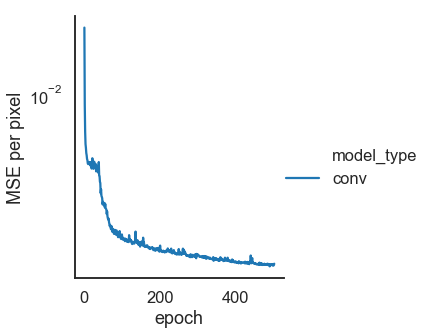

In [4]:
# data_queried = metrics[~pd.notna(metrics.test_loss)]
# lab = 'steinmetz'
data_queried = metrics_df[
    (metrics_df.dtype=='val') & 
    (metrics_df.epoch>0) & 
    (metrics_df.data==lab)]

y_axis = 'loss' # 'test_loss' | 'test_r2'
plot_type = 'line'
hue = 'model_type'
x_axis = 'epoch' # 'layers' | 'layer_size' | 'pred' | 'lags'

if len(data_queried.data.unique()) > 1:
    col = 'data'
    col_wrap = 2
    splt = sns.relplot(
        x=x_axis, y=y_axis, hue=hue, kind=plot_type, col=col, col_wrap=2,
        data=data_queried)
    for i, ax in enumerate(splt.axes):
        ax[0].set_yscale('log')
        if i == 0:
            ax[0].set_ylabel('MSE per pixel')
else:
    splt = sns.relplot(
        x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=data_queried)
    splt.ax.set_yscale('log')
    splt.ax.set_ylabel('MSE per pixel')
#     splt.ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#     splt.ax.ticklabel_format(axis='y', style='sci', scilimits=(1, 2))  # (1, 2) a hack
#     splt._legend.set_title('Model\ntype')
    
if save_outputs:
    save_file = os.path.join(
        results_dir, str('%s_%02i_dim_val_losses' % (lab, hparams['n_ae_latents'])))
else:
    save_file = None
    
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')   
    
plt.show()

### plot conv vs linear test losses

In [ ]:
data_queried = metrics_df[metrics_df.dtype=='test']
y_axis = 'loss'
plot_type = 'bar'  # 'bar' | 'box' | 'boxen'
hue = 'model_type'
x_axis = 'data'

splt = sns.catplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=data_queried)

plt.ylabel('MSE per pixel')
plt.xlabel('')
splt.ax.set_xticklabels(data_queried.data.unique(), rotation=45, ha='right')
splt.ax.set_yscale('log')
splt.ax.set_yticks([3e-3, 1e-3, 3e-4, 1e-4])
splt.ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
splt.ax.ticklabel_format(axis='y', style='sci', scilimits=(1, 2))  # (1, 2) a hack
splt._legend.set_title('Model type')

if save_outputs:
    save_file = os.path.join(results_dir, 'all_ae_test_losses')
    if save_file is not None:
        plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')
else:
    save_file = None
    
plt.show()

# 2. Plot test losses as a function of latents

### load results

In [4]:
hparams = {
    'data_dir': '/media/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'experiment_name': 'ae-dim-test',
    'model_class': 'ae'}
labs = ['musall', 'steinmetz', 'steinmetz-face']
model_types = ['conv', 'linear']
n_latents = [4, 8, 16, 32]
# n_latents = [3, 6, 9, 12]

metrics_df = []
for lab in labs:
    get_lab_example(hparams, lab)
    if lab == 'musall':
        hparams['animal'] = 'mSM36'
        hparams['session'] = 'all'
    elif lab == 'steinmetz':
        hparams['expt'] = '8-probe'
        hparams['animal'] = 'mouse-02'
        hparams['session'] = 'session-01'
    elif lab == 'steinmetz-face':
        hparams['expt'] = '8-probe-face'
        hparams['animal'] = 'mouse-02'
        hparams['session'] = 'session-01'
    for model_type in model_types:
        hparams['model_type'] = model_type
        for n_ae_latents in n_latents:
            hparams['n_ae_latents'] = n_ae_latents
            hparams['session_dir'], sess_ids = get_output_session_dir(hparams)
            expt_dir = get_expt_dir(hparams)
            try:
                model_version = get_best_model_version(expt_dir)
            except ValueError:
                print('could not find model in %s; skipping' % expt_dir)
                continue
            metric_file = os.path.join(expt_dir, model_version[0], 'metrics.csv')
            metrics = pd.read_csv(metric_file)
            for i, row in metrics.iterrows():
                if 'test_loss' in row:
                    metrics_df.append(pd.DataFrame({
                        'epoch': row['epoch'],
                        'loss': row['test_loss'],
                        'n_latents': n_ae_latents,
                        'dtype': 'test',
                        'model_type': model_type,
                        'data': lab
                    }, index=[0]))
metrics_df = pd.concat(metrics_df)

### plot conv vs ae test losses as a function of latents

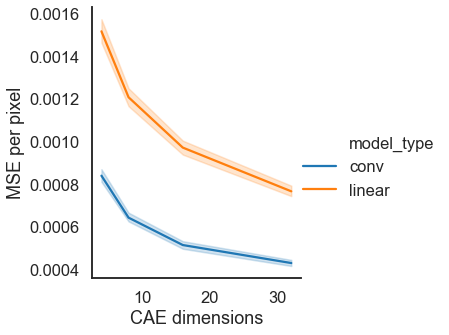

In [13]:
# plot single
save_outputs = True
format = 'pdf'
results_dir = '/home/mattw/results/behavenet_figs_final/'

lab = 'musall'
data_queried = metrics_df[(metrics_df.dtype=='test') & (metrics_df.data==lab)]
y_axis = 'loss'
plot_type = 'line'
hue = 'model_type'
x_axis = 'n_latents'

splt = sns.relplot(x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=data_queried)
# for i, ax in enumerate(splt.axes):
#     ax[i].set_xlabel('CAE dimensions')
#     if i == 0:
#         ax[0].set_ylabel('MSE per pixel')
#     ax[i].set_xscale('log')
#     ax[i].set_xticks(n_latents)
#     ax[i].set_xticklabels(n_latents)

splt.ax.set_ylabel('MSE per pixel')
splt.ax.set_xlabel('CAE dimensions')
# splt.ax.set_xscale('log')
# splt.ax.set_xticks(n_latents)
# splt.ax.set_xticklabels(n_latents)    


if save_outputs:
    save_file = os.path.join(results_dir, str('%s_ae' % lab), 'conv_vs_linear_mse')
else:
    save_file = None
if save_file is not None:
    plt.savefig(save_file + '.' + format, dpi=300, format=format)

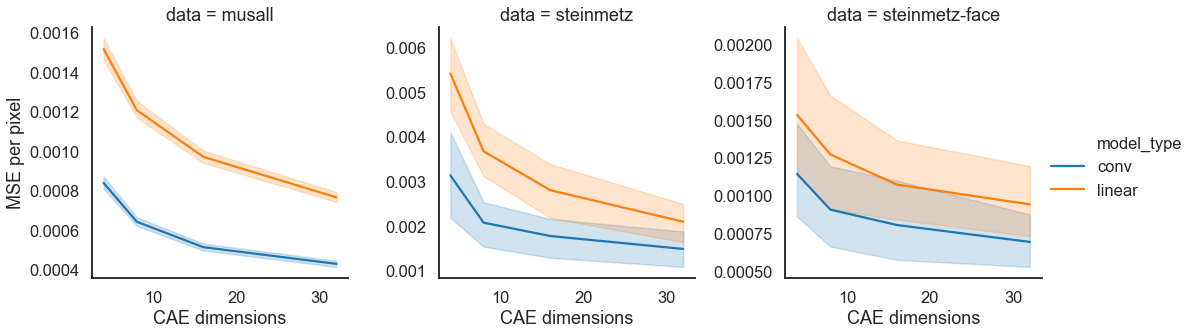

In [22]:
# plot single
save_outputs = True
format = 'pdf'
results_dir = '/home/mattw/results/behavenet_figs_final/'

data_queried = metrics_df[(metrics_df.dtype=='test')]
y_axis = 'loss' # 'test_loss' | 'test_r2'
plot_type = 'line'
hue = 'model_type'
x_axis = 'n_latents' # 'layers' | 'layer_size' | 'pred' | 'lags'
col = 'data'

splt = sns.relplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, col=col, data=data_queried,
    facet_kws={'sharey': False, 'sharex': True})

# splt = sns.relplot(
#     x=x_axis, y=y_axis, hue=hue, kind=plot_type, col=col, data=data_queried)
for i, ax in enumerate(splt.axes[0]):
    ax.set_xlabel('CAE dimensions')
    if i == 0:
        ax.set_ylabel('MSE per pixel')
# ax[2].set_xlabel('CAE dimensions')

if save_outputs:
    save_file = os.path.join(results_dir, 'all_ae', 'conv_vs_linear_mse')
else:
    save_file = None
if save_file is not None:
    plt.savefig(save_file + '.' + format, dpi=300, format=format)

# 3. Make reconstruction movies

Generator contains 2 SingleSessionDatasetBatchedLoad objects:
	signals: ['images']
	transforms: [None]
	paths: ['/media/mattw/data/musall/vistrained/mSM36/05-Dec-2017/data.hdf5']

	signals: ['images']
	transforms: [None]
	paths: ['/media/mattw/data/musall/vistrained/mSM36/07-Dec-2017/data.hdf5']


Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/multisession-00/ae/conv/09_latents/ae-dim-test-500/version_0/meta_tags.pkl
video saved to /home/mattw/results/behavenet_figs_final/musall_ae/musall_09_dim_recon_ae.mp4


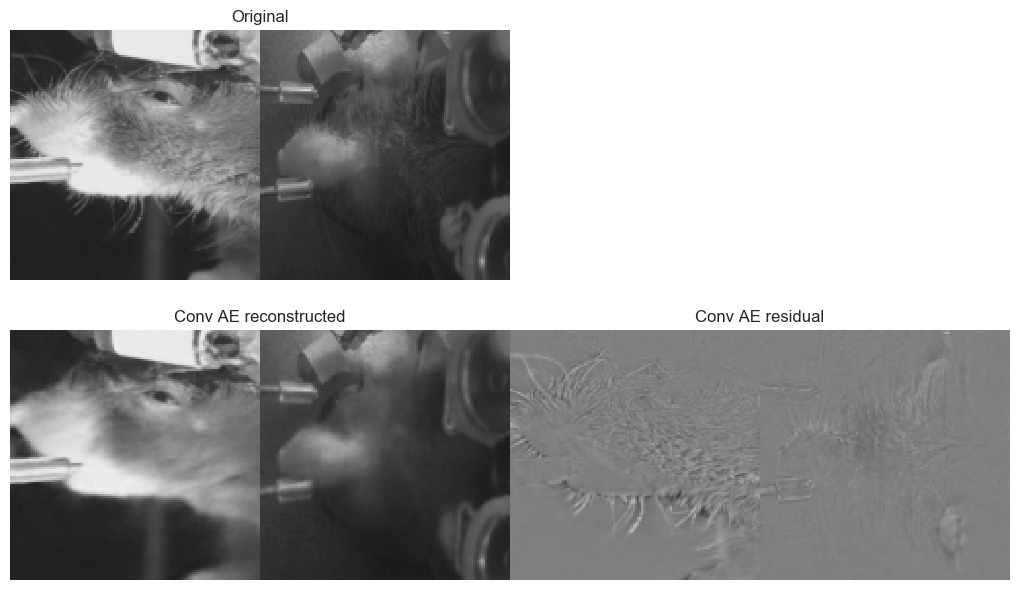

In [28]:
from behavenet.analyses.ae_utils import make_ae_reconstruction_movie
from behavenet.fitting.utils import get_lab_example, get_output_session_dir, get_expt_dir
from behavenet.data.utils import get_data_generator_inputs
from behavenet.data.data_generator import ConcatSessionsGenerator

save_outputs = True
include_linear = False
version = 'best'
sess_idx = 0
hparams = {
    'data_dir': '/media/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'experiment_name': 'ae-dim-test-500',
    'lin_experiment_name': 'ae-dim-test',
    'model_class': 'ae',
    'model_type': 'conv'}

labs = ['musall'] #['steinmetz', 'steinmetz-face', 'musall']

for lab in labs:
    get_lab_example(hparams, lab)
    if lab == 'steinmetz':
        hparams['n_ae_latents'] = 8
        hparams['expt'] = '8-probe'
        hparams['animal'] = 'mouse-02'
        hparams['session'] = 'session-01'
        trial_splits = {'train_tr': 5, 'val_tr': 1, 'test_tr': 1, 'gap_tr': 1}
    elif lab == 'steinmetz-face':
        hparams['n_ae_latents'] = 8
        hparams['expt'] = '8-probe-face'
        hparams['animal'] = 'mouse-02'
        hparams['session'] = 'session-01'
        trial_splits = {'train_tr': 5, 'val_tr': 1, 'test_tr': 1, 'gap_tr': 1}
    elif lab == 'musall':
        hparams['n_ae_latents'] = 9
        hparams['animal'] = 'mSM36'
        hparams['session'] = 'all'
        trial_splits = {'train_tr': 8, 'val_tr': 1, 'test_tr': 1, 'gap_tr': 0}
    hparams['frame_rate'] = 15
    
    hparams['session_dir'], sess_ids = get_output_session_dir(hparams)
    hparams['expt_dir'] = get_expt_dir(hparams)
    hparams, signals, transforms, paths = get_data_generator_inputs(hparams, sess_ids)
    data_generator = ConcatSessionsGenerator(
        hparams['data_dir'], sess_ids, 
        signals_list=signals, transforms_list=transforms, paths_list=paths,
        device='cpu', as_numpy=False, batch_load=True, rng_seed=0, 
        trial_splits=trial_splits)
    print(data_generator)

    trial = data_generator.datasets[sess_idx].batch_indxs['test'][2]
    # 4 good for steinmetz/2-probe
    # 2 good for steinmetz/8-probe/mouse-02

    filename = str('%s_%02i_dim_recon_ae' % (lab, hparams['n_ae_latents']))
    if include_linear:
        filename += '_with_linear'

    make_ae_reconstruction_movie(
        hparams, version=version, 
        save_file=os.path.join(results_dir, '%s_ae' % lab, filename), 
        include_linear=include_linear, trial=trial)

# 4. Reconstruct frames

In [3]:
# Get example figure for every data type
import numpy as np
from behavenet.data.utils import get_best_model_and_data
from behavenet.fitting.utils import get_lab_example, get_output_session_dir, get_expt_dir
from behavenet.models import AE

labs = ['musall', 'steinmetz', 'steinmetz-face']
model_types = ['conv', 'linear']
example_images = {lab: {m: None for m in model_types} for lab in labs}
for lab in labs:
    for model_type in model_types:      
        hparams = {
            'data_dir': '/media/mattw/data/',  # might be a different path than what is saved in hparams
            'tt_save_path': '/home/mattw/results/behavenet',
            'experiment_name': 'ae-dim-test',
            'model_class': 'ae',
            'model_type': model_type
        }
        get_lab_example(hparams, lab)
        if lab == 'musall':
            hparams['session'] = 'all'        
        model_cae, data_generator = get_best_model_and_data(hparams, AE, version='best')
        trial_idx = data_generator.datasets[0].batch_indxs['test'][2]
        
        recon_output, _ = model_cae(data_generator.datasets[0][trial_idx]['images'])
        example_images[lab][model_type]=recon_output.cpu().detach().numpy()
        example_images[lab]['orig'] = data_generator.datasets[0][trial_idx]['images'].cpu().detach().numpy()
        
        if hparams['lab'] == 'musall':
            example_images[lab]['orig'] = np.transpose(example_images[lab]['orig'],(0,1,3,2))
            example_images[lab][model_type] = np.transpose(example_images[lab][model_type],(0,1,3,2))
        example_images[lab]['orig'] = np.concatenate([example_images[lab]['orig'][:,j] for j in range(example_images[lab]['orig'].shape[1])],axis=1)
        example_images[lab][model_type] = np.concatenate([example_images[lab][model_type][:,j] for j in range(example_images[lab][model_type].shape[1])],axis=1)

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/multisession-00/ae/conv/08_latents/ae-dim-test/version_1/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/multisession-00/ae/linear/08_latents/ae-dim-test/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/8-probe/mouse-02/session-01/ae/conv/08_latents/ae-dim-test/version_1/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/8-probe/mouse-02/session-01/ae/linear/08_latents/ae-dim-test/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/8-probe-face/mouse-02/session-01/ae/conv/08_latents/ae-dim-test/version_1/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/8-probe-face/mouse-02/session-01/ae/linear/08_latents/ae-dim-test/version_0/meta_tags.pkl


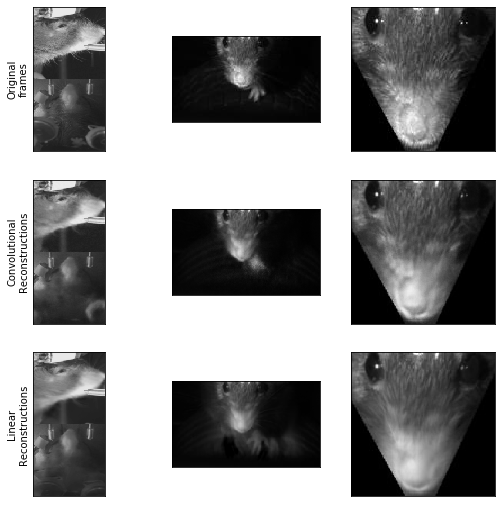

In [9]:
import os
import matplotlib.pyplot as plt

save_figure = True
results_dir = '/home/mattw/results/behavenet_figs_final/'
format = 'pdf'

fig = plt.figure(figsize=(9, 9))
idx = 32
for i, lab in enumerate(labs):
    plt.subplot(3, 3, i+1)
    plt.imshow(example_images[lab]['orig'][idx, :, :], vmin=0, vmax=1, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Original\nframes')
for j, model_type in enumerate(model_types):
    for i, lab in enumerate(labs):
        plt.subplot(3, 3, 4 + 3 * j + i)
        plt.imshow(example_images[lab][model_type][idx, :, :], vmin=0, vmax=1, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if i == 0 and j == 0:
            plt.ylabel('Convolutional\nReconstructions')
        elif i == 0 and j == 1:
            plt.ylabel('Linear\nReconstructions')
if save_figure:
    save_file = os.path.join(results_dir, 'all_ae', 'conv_vs_linear_reconstructions_vert')
else:
    save_file = None
if save_file is not None:
    plt.savefig(save_file + '.' + format, dpi=300, format=format)
plt.show()    